In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/DPO/USPTO_50K/Hydrogen/cluster.pkl.gz')

In [ ]:
data_issue = [value for value in data if value['Reaction Type'] not in ['Single Cyclic', 'Complex Cyclic']]

In [ ]:
import pandas as pd
pd.DataFrame(data_issue)['Reaction Type'].value_counts()

In [ ]:
acyclic = [value for value in data_issue if value['Reaction Type'] in ['Acyclic']]
other = [value for value in data_issue if value['Reaction Type'] not in ['Acyclic']]

In [ ]:
acyclic_id = [value['R-id'] for value in acyclic]
other_id = [value['R-id'] for value in other]

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(acyclic[10]['ITSGraph'])

In [ ]:
vis_graph.vis_three_graph(other[11]['ITSGraph'])

In [ ]:
train = load_database('./Data/DPO/USPTO_50K/train.json.gz')

In [11]:
acyclic_reactions = [value for value in train if value['R-id'] in acyclic_id]
other_reactions = [value for value in train if value['R-id'] in other_id]


# Test Acyclic

In [1]:
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster

In [13]:
its_good, _ = ITSExtraction.parallel_process_smiles(acyclic_reactions[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] [1

In [2]:
test = [{'R-id': 26555,
  'reactions': 'COC(=O)c1cc(C(=O)c2c(F)cc(F)cc2F)c[nH]1.[H].[H].[H].[H]>>COC(=O)c1cc(Cc2c(F)cc(F)cc2F)c[nH]1.O',
  'local_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'rxn_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'graphormer': '[F:12][c:11]1[cH:13][c:14]([cH:16][c:17]([F:18])[c:10]1[C:8]([c:7]1[cH:6][c:5]([nH:20][cH:19]1)[C:3]([O:2][CH3:1])=[O:4])=[O:9])[F:15].[H:21][H:22].[H:23][H:24]>>[OH2:9].[cH:13]1[c:11]([F:12])[c:10]([c:17]([cH:16][c:14]1[F:15])[F:18])[CH2:8][c:7]1[cH:19][nH:20][c:5]([C:3](=[O:4])[O:2][CH3:1])[cH:6]1',
  'class': 6}]

its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s


In [3]:
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=4, verbose=2, return_all = True
            )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


4


ERROR:root:{'R-id': 26555, 'ITSGraph': (<networkx.classes.graph.Graph object at 0x7faa050450d0>, <networkx.classes.graph.Graph object at 0x7faa028d4fd0>, <networkx.classes.graph.Graph object at 0x7faa028d6750>), 'GraphRules': (<networkx.classes.graph.Graph object at 0x7faa028e0ed0>, <networkx.classes.graph.Graph object at 0x7faa028e11d0>, <networkx.classes.graph.Graph object at 0x7faa028e1490>)}


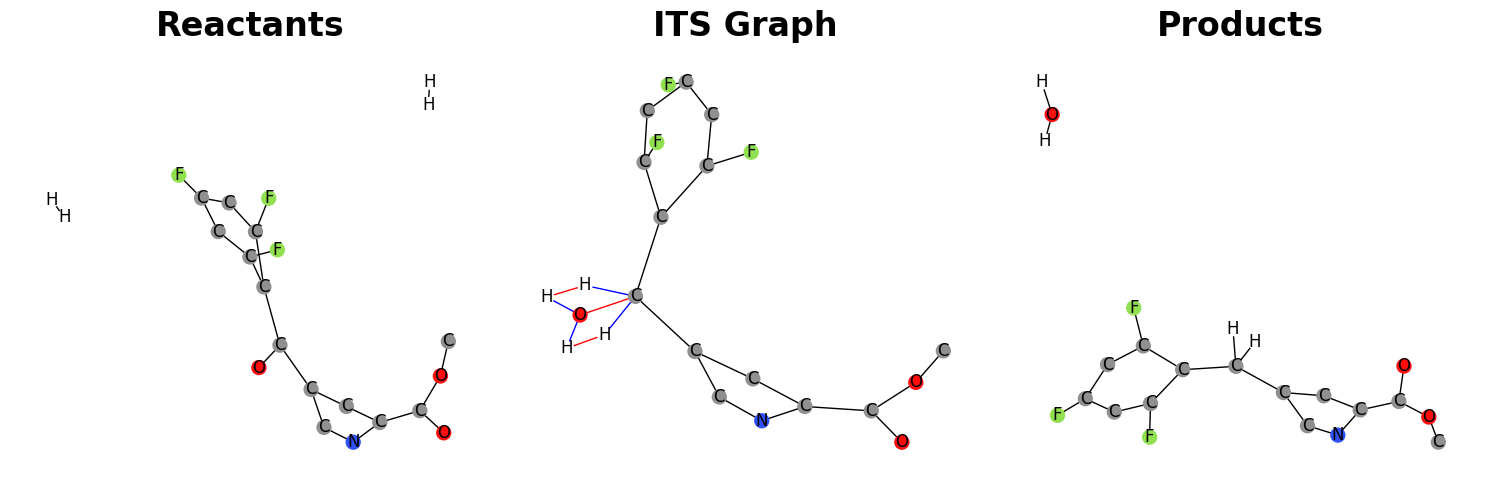

In [5]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

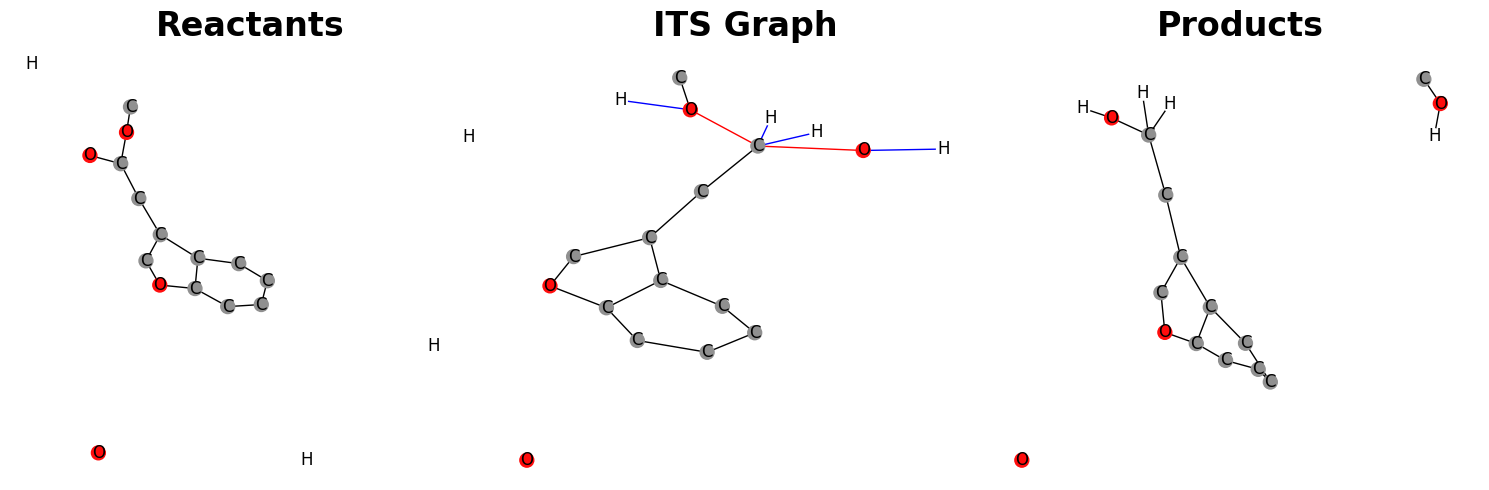

In [21]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)

vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

# Disconnected

In [ ]:
# test = [{'R-id': 30683,
#  'reactions': 'CC(C)(C)OC(=O)N1CCC(=O)CC1.N#Cc1ccc(N)cc1.[H].[H]>>CC(C)(C)OC(=O)N1CCC(Nc2ccc(C#N)cc2)CC1.O',
#  'local_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
#  'rxn_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
#  'graphormer': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11]([CH2:13][CH2:14]1)=[O:12].[H:24][H:25].[cH:19]1[cH:18][c:17]([cH:23][cH:22][c:20]1[NH2:21])[C:16]#[N:15]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([CH2:13][CH2:14]1)[NH:21][c:20]1[cH:19][cH:18][c:17]([cH:23][cH:22]1)[C:16]#[N:15].[OH2:12]',
#  'class': 1}]

# its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

In [ ]:
from SynTemp.SynITS.its_extraction import ITSExtraction
its_good, _ = ITSExtraction.parallel_process_smiles(other_reactions, ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(its_good[1]['ITSGraph'])

In [ ]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=1, verbose=2
            )

In [ ]:
len(batch_processed)

In [ ]:
good = [value for value in batch_processed if value['ITSGraph']]

In [ ]:
rc_list = [value['GraphRules'][2] for value in good]

In [ ]:
from SynTemp.SynUtils.graph_utils import check_graph_connectivity

connect = [value for value in rc_list if check_graph_connectivity(value)=='Connected']
disconnect = [value for value in rc_list if check_graph_connectivity(value)=='Disconnected']

In [ ]:
len(connect)

In [ ]:
vis_graph.vis_three_graph(batch_processed[11]['GraphRules'])

In [ ]:
its_good[0]['ITSGraph']

In [ ]:
batch_processed

In [ ]:
vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

In [27]:
rsmi = 'CO.O=C(O)c1ccc(Br)c(C(F)(F)F)c1>>COC(=O)c1ccc(Br)c(C(F)(F)F)c1.O'

In [31]:
rsmi =  'CO.CC(=O)O>>CC(=O)OC.O'

In [32]:
from SynTemp.SynAAM.graphormer_wrapper import map_with_graphormer
map_with_graphormer(rsmi)

'[C:4]([CH3:3])(=[O:6])[OH:5].[CH3:1][OH:2]>>[CH3:3][C:4]([O:2][CH3:1])=[O:6].[OH2:5]'

In [28]:
from SynTemp.SynAAM.rxn_mapper_wrapper import map_with_rxn_mapper
map_with_rxn_mapper(rsmi)

'[CH3:1][OH:2].[O:4]=[C:3]([OH:16])[c:5]1[cH:6][cH:7][c:8]([Br:9])[c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][cH:7][c:8]([Br:9])[c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1.[OH2:16]'

In [39]:
a = load_database('./Data/DPO/USPTO_balance/USPTO_50K_bad_reactions.json.gz')
b = load_database('./Data/DPO/USPTO_unbalance/USPTO_50K_aam_reactions.json.gz')

In [2]:
from joblib import Parallel, delayed
from typing import Dict, Tuple, List, Optional
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
from SynTemp.SynUtils.graph_utils import check_graph_type


class ITSRefinement:
    @staticmethod
    def process_and_check_graph(graph_data: Dict, column: str) -> Tuple[Dict, str]:
        """
        Process the graph data and check its type.

        Parameters:
        - graph_data (Dict): The graph data to be processed.
        - column (str): The column name of the graph data.

        Returns:
        - Tuple[Dict, str]: Processed graph data and its type.
        """
        processed_data = ITSHAdjuster.process_single_graph_data(
            graph_data, column, return_all=True
        )
        if len(processed_data["GraphRules"][2].nodes) > 0:
            type_of_graph = check_graph_type(processed_data["GraphRules"][2])
        else:
            type_of_graph = "None"
        return processed_data, type_of_graph

    @staticmethod
    def process_dict(
        input_graph: Dict,
        column: str = "ITSGraph",
        mapper_types: List[str] = ["rxn_mapper", "graphormer", "local_mapper"],
    ) -> Optional[Dict]:
        """
        Process a graph dictionary to find a 'Single Cyclic' graph.

        Parameters:
        - input_graph (Dict): The graph dictionary to be processed.

        Returns:
        - Dict: The processed graph data with 'Single Cyclic' type or None if not found.
        """
        uncertain_graph = []
        results = []

        for mapper in mapper_types:
            graph_data = {column: input_graph.get(mapper)}
            if graph_data[column]:
                try:
                    processed_data, type_of_graph = (
                        ITSRefinement.process_and_check_graph(graph_data, column)
                    )
                    uncertain_graph.append(processed_data)
                    results.append(type_of_graph)
                    if type_of_graph == "Single Cyclic":
                        processed_data["R-id"] = input_graph.get("R-id", "")
                        return processed_data
                except ValueError:
                    return None
        return None

    @staticmethod
    def process_graphs_in_parallel(
        graph_dicts: List[Dict],
        mapper_types: List[str] = ["rxn_mapper", "graphormer", "local_mapper"],
        n_jobs: int = 4,
        verbose: int = 1,
    ) -> List[Optional[Dict]]:
        """
        Process multiple graph dictionaries in parallel to find 'Single Cyclic' graphs.

        Parameters:
        - graph_dicts (List[Dict]): A list of graph dictionaries to be processed.
        - n_jobs (int): The number of concurrent jobs.
        - verbose (int): The verbosity level.

        Returns:
        - List[Optional[Dict]]: A list of processed graph data.
        """
        results = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(ITSRefinement.process_dict)(graph_dict, "ITSGraph", mapper_types)
            for graph_dict in graph_dicts
        )
        return results


In [3]:
from SynTemp.SynUtils.utils import load_from_pickle

In [4]:
its_wrong = load_from_pickle('./Data/DPO/USPTO_50K/Hydrogen/USPTO_50K_its_incorrect.pkl.gz')

In [53]:
its_wrong_id = [value['R-id'] for value in its_wrong]

In [19]:
refine = ITSRefinement.process_graphs_in_parallel(its_wrong[0:10])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.7s finished


In [20]:
refine

[None,
 None,
 None,
 {'ITSGraph': (<networkx.classes.graph.Graph at 0x7fc8bbc22790>,
   <networkx.classes.graph.Graph at 0x7fc8ba645e90>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7fc8ba306bd0>,
   <networkx.classes.graph.Graph at 0x7fc8ba327e90>),
  'R-id': 28417},
 None,
 {'ITSGraph': (<networkx.classes.graph.Graph at 0x7fc8bc01f810>,
   <networkx.classes.graph.Graph at 0x7fc8b9ffb850>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7fc8b9def7d0>,
   <networkx.classes.graph.Graph at 0x7fc8b9e64150>),
  'R-id': 9844},
 None,
 {'ITSGraph': (<networkx.classes.graph.Graph at 0x7fc8b9cff990>,
   <networkx.classes.graph.Graph at 0x7fc8b9a93610>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7fc8b9659ad0>,
   <networkx.classes.graph.Graph at 0x7fc8b9680fd0>),
  'R-id': 43336},
 {'ITSGraph': (<networkx.classes.graph.Graph at 0x7fc8cb7bf190>,
   <networkx.classes.graph.Graph at 0x7fc8b9141c90>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7fc8b8c3cb50>,
   <ne

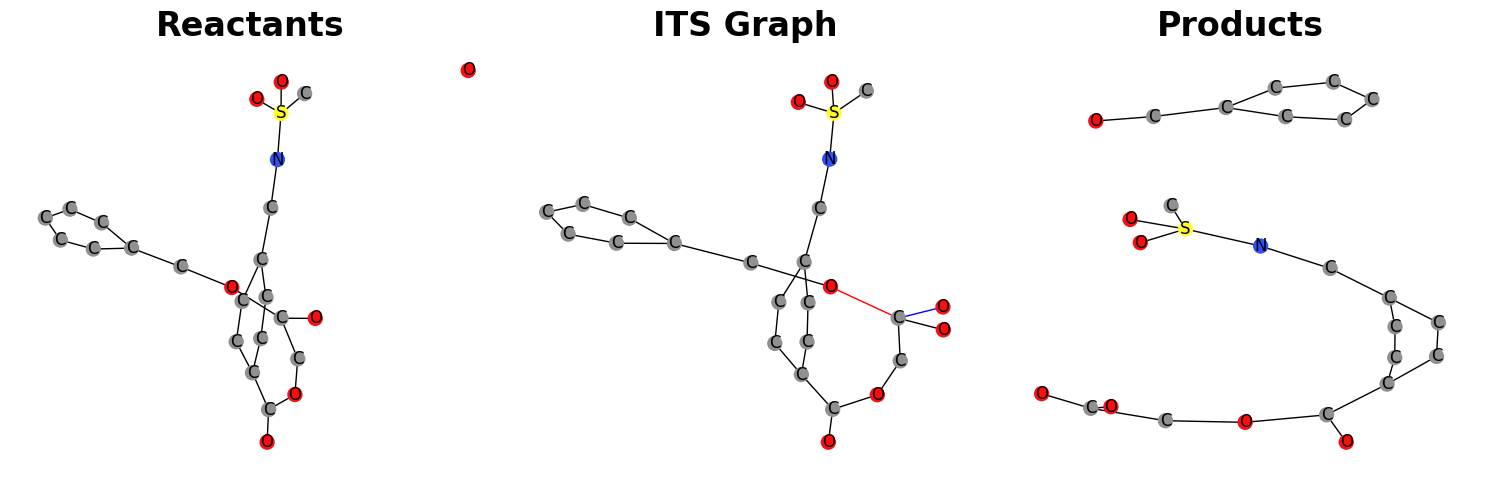

In [17]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(refine[12]['rxn_mapper'])

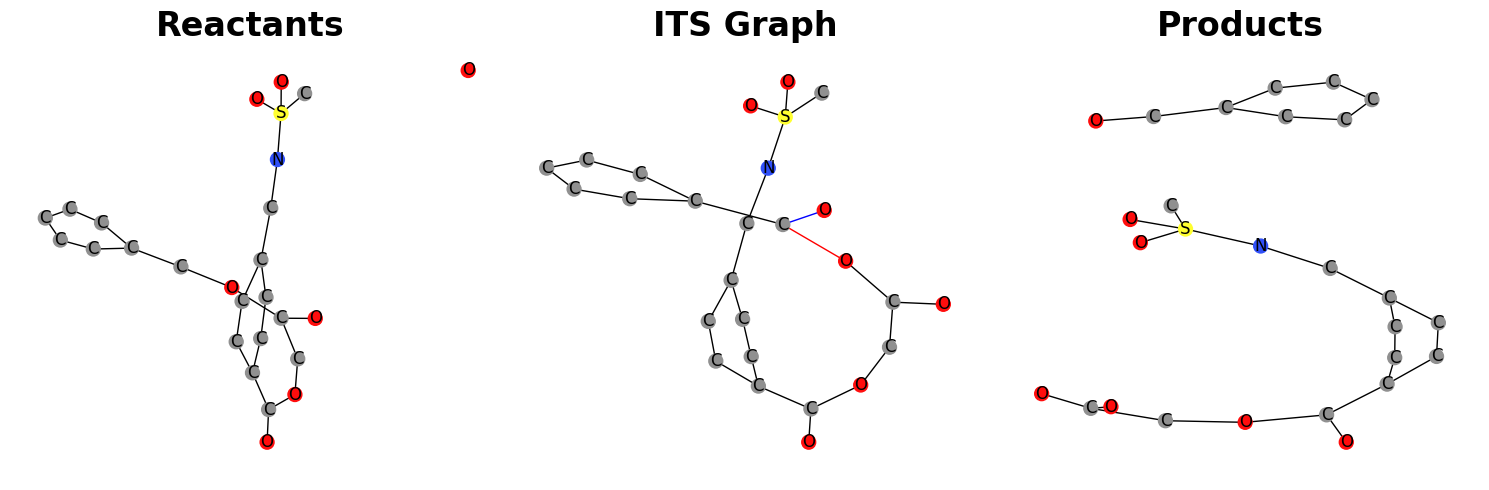

In [18]:
vis_graph.vis_three_graph(its_wrong[12]['local_mapper'])

In [54]:
train = load_database('./Data/DPO/USPTO_50K/train.json.gz')
wrong_reactions = [value for value in train if value['R-id'] in its_wrong_id]


In [58]:
wrong_reactions[100]

{'R-id': 36904,
 'reactions': 'COC[C@H]1C[C@@](Cc2cscn2)(C(=O)OC(C)(C)C)N(C(=O)c2ccc(C(C)(C)C)c(OC)c2)[C@H]1c1ncc(C)s1.O>>COC[C@H]1C[C@@](Cc2cscn2)(C(=O)O)N(C(=O)c2ccc(C(C)(C)C)c(OC)c2)[C@H]1c1ncc(C)s1.CC(C)(C)O',
 'local_mapper': '[CH3:1][O:2][CH2:3][C@H:4]1[CH2:5][C@@:6]([CH2:7][c:8]2[cH:9][s:10][cH:11][n:12]2)([C:13](=[O:14])[O:15][C:39]([CH3:38])([CH3:40])[CH3:41])[N:16]([C:17](=[O:18])[c:19]2[cH:20][cH:21][c:22]([C:23]([CH3:24])([CH3:25])[CH3:26])[c:27]([O:28][CH3:29])[cH:30]2)[C@H:31]1[c:32]1[n:33][cH:34][c:35]([CH3:36])[s:37]1.[OH2:42]>>[CH3:1][O:2][CH2:3][C@H:4]1[CH2:5][C@@:6]([CH2:7][c:8]2[cH:9][s:10][cH:11][n:12]2)([C:13](=[O:14])[OH:15])[N:16]([C:17](=[O:18])[c:19]2[cH:20][cH:21][c:22]([C:23]([CH3:24])([CH3:25])[CH3:26])[c:27]([O:28][CH3:29])[cH:30]2)[C@H:31]1[c:32]1[n:33][cH:34][c:35]([CH3:36])[s:37]1.[CH3:38][C:39]([CH3:40])([CH3:41])[OH:42]',
 'rxn_mapper': '[CH3:1][O:2][CH2:3][C@H:4]1[CH2:5][C@@:6]([CH2:7][c:8]2[cH:9][s:10][cH:11][n:12]2)([C:13](=[O:14])[O:42][C:39]([CH3

In [57]:
len(wrong_reactions)

5238

In [1]:
import networkx as nx
from typing import Tuple, Dict, Any
from copy import deepcopy


class ITSConstruction:
    @staticmethod
    def ITSGraph(
        G: nx.Graph,
        H: nx.Graph,
        ignore_aromaticity: bool = False,
        attributes_defaults: Dict[str, Any] = None,
        balance_its : bool = True,
    ) -> nx.Graph:
        """
        Creates a Combined Graph Representation (CGR) from two input graphs G and H.

        This function merges the nodes of G and H, preserving their attributes. Edges are added
        based on their presence in G and/or H, with special labeling for edges unique to one graph.

        Parameters:
        - G (nx.Graph): The first input graph.
        - H (nx.Graph): The second input graph.
        - ignore_aromaticity (bool): Whether to ignore aromaticity in the graphs. Defaults to False.
        - attributes_defaults (Dict[str, Any]): A dictionary of default attributes to use for nodes that are not present in either G or H.

        Returns:
        - nx.Graph: The Combined Graph Representation as a new graph instance.
        """
        # Create a null graph from a copy of G to preserve attributes
        # Choose the graph with more nodes or the graph H depending on the 'balance_its' flag
        if (balance_its and len(G.nodes()) <= len(H.nodes())) or (not balance_its and len(G.nodes()) >= len(H.nodes())):
            ITS = deepcopy(G)
        else:
            ITS = deepcopy(H)

        ITS.remove_edges_from(list(ITS.edges()))

        # Initialize a dictionary to hold node types
        typesDict = dict()

        # Add typeG and typeH attributes, or default attributes for "*" unknown elements
        for v in list(ITS.nodes()):
            # Check if v is in both G and H
            if v not in G.nodes() or v not in H.nodes():
                continue
            else:
                typesG = ITSConstruction.get_node_attributes_with_defaults(
                    G, v, attributes_defaults
                )  # node attribute in reactant graph
                typesH = ITSConstruction.get_node_attributes_with_defaults(
                    H, v, attributes_defaults
                )  # node attribute in product graph
                typesDict[v] = (typesG, typesH)

        nx.set_node_attributes(ITS, typesDict, "typesGH")

        # Add edges from G and H
        ITS = ITSConstruction.add_edges_to_ITS(ITS, G, H, ignore_aromaticity)

        return ITS

    @staticmethod
    def get_node_attribute(graph: nx.Graph, node: int, attribute: str, default):
        """
        Retrieves a specific attribute for a node in a graph, returning a default value if the attribute is missing.

        Parameters:
        - graph (nx.Graph): The graph from which to retrieve the node attribute.
        - node (int): The node identifier.
        - attribute (str): The attribute to retrieve.
        - default: The default value to return if the attribute is missing.

        Returns:
        - The value of the node attribute, or the default value if the attribute is missing.
        """
        try:
            return graph.nodes[node][attribute]
        except KeyError:
            return default

    @staticmethod
    def get_node_attributes_with_defaults(
        graph: nx.Graph, node: int, attributes_defaults: Dict[str, Any] = None
    ) -> Tuple:
        """
        Retrieves node attributes from a graph, assigning default values if they are missing. Allows
        for an optional dictionary of attribute-default value pairs to specify custom attributes and defaults.

        Parameters:
        - graph (nx.Graph): The graph from which to retrieve node attributes.
        - node (int): The node identifier.
        - attributes_defaults (Dict[str, Any], optional): A dictionary specifying attributes and their default values.

        Returns:
        - Tuple: A tuple containing the node attributes in the order specified by attributes_defaults.
        """
        if attributes_defaults is None:
            attributes_defaults = {
                "element": "*",
                "aromatic": False,
                "hcount": 0,
                "charge": 0,
                "neighbors": ["", ""],
            }

        return tuple(
            ITSConstruction.get_node_attribute(graph, node, attr, default)
            for attr, default in attributes_defaults.items()
        )

    @staticmethod
    def add_edges_to_ITS(
        ITS: nx.Graph, G: nx.Graph, H: nx.Graph, ignore_aromaticity: bool = False
    ) -> nx.Graph:
        """
        Adds edges to the Combined Graph Representation (ITS) based on the edges of G and H,
        and returns a new graph without modifying the original ITS.

        Parameters:
        - ITS (nx.Graph): The initial combined graph representation.
        - G (nx.Graph): The first input graph.
        - H (nx.Graph): The second input graph.
        - ignore_aromaticity (bool): Whether to ignore aromaticity in the graphs. Defaults to False.

        Returns:
        - nx.Graph: The updated graph with added edges.
        """
        new_ITS = deepcopy(ITS)

        # Add edges from G and H
        for graph_from, graph_to, reverse in [(G, H, False), (H, G, True)]:
            for u, v in graph_from.edges():
                if not new_ITS.has_edge(u, v):
                    if graph_to.has_edge(u, v) or graph_to.has_edge(v, u):
                        edge_label = (
                            (graph_from[u][v]["order"], graph_to[u][v]["order"])
                            if graph_to.has_edge(u, v)
                            else (
                                (graph_from[v][u]["order"], graph_to[v][u]["order"])
                                if reverse
                                else (
                                    graph_from[u][v]["order"],
                                    graph_to[v][u]["order"],
                                )
                            )
                        )
                        new_ITS.add_edge(u, v, order=edge_label)
                    else:
                        edge_label = (
                            (graph_from[u][v]["order"], 0)
                            if not reverse
                            else (0, graph_from[u][v]["order"])
                        )
                        new_ITS.add_edge(u, v, order=edge_label)
        nodes_to_remove = [node for node in new_ITS.nodes() if not new_ITS.nodes[node]]
        new_ITS.remove_nodes_from(nodes_to_remove)
        new_ITS = ITSConstruction.add_standard_order_attribute(
            new_ITS, ignore_aromaticity
        )
        return new_ITS

    @staticmethod
    def add_standard_order_attribute(
        graph: nx.Graph, ignore_aromaticity: bool = False
    ) -> nx.Graph:
        """
        Adds a 'standard_order' attribute to each edge in the given NetworkX graph based on the 'order' attribute.
        The 'standard_order' is computed by subtracting the second element of the 'order' tuple from the first.
        If an element of the tuple is not an integer (e.g., '*'), it is treated as 0 for the computation.

        :param graph: A NetworkX graph whose edges have 'order' attributes as tuples.
        :return: A new NetworkX graph with 'standard_order' attributes added to each edge.
        """
        new_graph = graph.copy()

        for u, v, data in new_graph.edges(data=True):
            if "order" in data and isinstance(data["order"], tuple):
                # Extract order values, replacing non-ints with 0
                first_order = data["order"][0]
                second_order = data["order"][1]
                # Compute standard order
                standard_order = first_order - second_order
                if ignore_aromaticity:
                    if abs(standard_order) < 1:  # to ignore aromaticity
                        standard_order = 0
                # Update the edge data with a new attribute 'standard_order'
                new_graph[u][v]["standard_order"] = standard_order
            else:
                # If 'order' attribute is missing or not a tuple, set 'standard_order' to 0
                new_graph[u][v]["standard_order"] = 0

        return new_graph


In [16]:
import networkx as nx
from typing import Dict, List, Tuple, Iterable
import itertools
from joblib import Parallel, delayed
from copy import deepcopy
from SynTemp.SynRule.rules_extraction import RuleExtraction
#from SynTemp.SynITS.its_construction import ITSConstruction
from SynTemp.SynUtils.graph_utils import (
    check_hcount_change,
    check_explicit_hydrogen,
    get_priority,
)
from SynTemp.SynITS.its_extraction import ITSExtraction

import logging

class ITSHAdjuster:

    @staticmethod
    def process_single_graph_data(
        graph_data: Dict,
        column: str,
        return_all: bool = False,
        ignore_aromaticity: bool = False,
        balance_its : bool = True,
    ) -> Dict:
        """
        Processes a single dictionary containing graph information by applying modifications based on hcount changes.
        Optionally handles aromaticity and provides different return behaviors based on the `return_all` flag.

        Args:
        graph_data (Dict): Dictionary containing graph information.
        column (str): Key where the graph tuple is stored.
        return_all (bool): Flag to return all data or just the most relevant. Default is False.
        ignore_aromaticity (bool): Flag to ignore aromaticity in the ITS construction. Default is False.

        Returns:
        Dict: Updated dictionary with new ITS and GraphRules if applicable.
        """
        graphs = deepcopy(graph_data)
        react_graph, prod_graph, its = graphs[column]
        logging.error(graphs)

        hcount_change = check_hcount_change(react_graph, prod_graph)
        if hcount_change == 0:
            graph_data = ITSHAdjuster.update_graph_data(
                graphs, react_graph, prod_graph, its
            )
        elif hcount_change < 5:
            graph_data = ITSHAdjuster.process_multiple_hydrogens(
                graphs, react_graph, prod_graph, its, ignore_aromaticity, return_all, balance_its
            )
        else:
            graph_data = ITSHAdjuster.process_high_hcount_change(
                graphs, react_graph, prod_graph, its, ignore_aromaticity, return_all, balance_its
            )

        return graph_data

    @staticmethod
    def update_graph_data(graph_data, react_graph, prod_graph, its):
        """
        Update graph data dictionary with new ITS and GraphRules based on the graphs provided.

        Args:
        graph_data (Dict): Existing graph data.
        react_graph (nx.Graph), prod_graph (nx.Graph), its: Graphs and ITS to use.

        Returns:
        Dict: Updated graph data dictionary.
        """
        graph_data["ITSGraph"] = (react_graph, prod_graph, its)
        graph_data["GraphRules"] = RuleExtraction.extract_reaction_rules(
            react_graph, prod_graph, its, extend=False, n_knn=1
        )
        return graph_data

    @staticmethod
    def process_multiple_hydrogens(
        graph_data, react_graph, prod_graph, its, ignore_aromaticity, return_all, balance_its,
    ):
        """
        Handles cases with hydrogen count changes between 2 and 4, inclusive.
        Manages the creation of multiple hydrogen node scenarios and evaluates their equivalence.

        Args:
        graph_data, react_graph, prod_graph, its, ignore_aromaticity, return_all as described.

        Returns:
        Dict: Updated graph data.
        """
        combinations_solution = ITSHAdjuster.add_hydrogen_nodes_multiple(
            react_graph, prod_graph
        )
        print(len(combinations_solution))
        its_list = [
            ITSConstruction.ITSGraph(i[0], i[1], ignore_aromaticity, balance_its=balance_its)
            for i in combinations_solution
        ]
        _, equivariant = ITSExtraction.check_equivariant_graph(its_list)
        pairwise_combinations = len(its_list) - 1
        if equivariant == pairwise_combinations:
            graph_data = ITSHAdjuster.update_graph_data(
                graph_data, *combinations_solution[0], its_list[0]
            )
        else:
            graph_data = ITSHAdjuster.process_high_hcount_change(
                graph_data, react_graph, prod_graph, its, ignore_aromaticity, return_all, balance_its
            )
        return graph_data

    @staticmethod
    def process_high_hcount_change(
        graph_data, react_graph, prod_graph, its, ignore_aromaticity, return_all,
        balance_its : bool = True,
    ):
        """
        Handles cases with hydrogen count changes of 5 or more.
        Similar to `process_multiple_hydrogens` but tailored for higher counts.

        Args:
        Same as `process_multiple_hydrogens`.

        Returns:
        Dict: Updated graph data.
        """
        combinations_solution = ITSHAdjuster.add_hydrogen_nodes_multiple(
            react_graph, prod_graph
        )
        its_list = [
            ITSConstruction.ITSGraph(i[0], i[1], ignore_aromaticity, balance_its=balance_its)
            for i in combinations_solution
        ]
        reaction_centers = [
            RuleExtraction.extract_reaction_rules(react_graph, prod_graph, i)[2]
            for i in its_list
        ]

        its_list, rc_list = get_priority(its_list, reaction_centers)
        _, equivariant = ITSExtraction.check_equivariant_graph(rc_list)
        pairwise_combinations = len(its_list) - 1
        if equivariant == pairwise_combinations:
            graph_data = ITSHAdjuster.update_graph_data(
                graph_data, *combinations_solution[0], its_list[0]
            )
        else:
            if return_all:
                graph_data = ITSHAdjuster.update_graph_data(
                    graph_data, react_graph, prod_graph, its
                )
            else:
                graph_data["ITSGraph"], graph_data["GraphRules"] = None, None
        return graph_data

    @staticmethod
    def process_graph_data_parallel(
        graph_data_list: List[Dict],
        column: str,
        n_jobs: int,
        verbose: int,
        return_all: bool = False,
        ignore_aromaticity: bool = False,
        balance_its : bool = True,
    ) -> List[Dict]:
        """
        Processes a list of dictionaries containing graph information in parallel.

        Parameters:
        - graph_data_list (List[Dict]): A list of dictionaries containing graph information.
        - column (str): The key in the dictionary where the graph tuple is stored.
        - n_jobs (int): The number of concurrent jobs.
        - verbose (int): The verbosity level.

        Returns:
        - List[Dict]: A list of dictionaries with the updated graph data.
        """
        processed_data = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(ITSHAdjuster.process_single_graph_data)(
                graph_data, column, return_all, ignore_aromaticity, balance_its
            )
            for graph_data in graph_data_list
        )

        return processed_data

    @staticmethod
    def add_hydrogen_nodes_multiple_utils(
        graph: nx.Graph,
        node_id_pairs: Iterable[Tuple[int, int]],
        atom_map_update: bool = True,
    ) -> nx.Graph:
        """
        Creates and returns a new graph with added hydrogen nodes based on the input graph and node ID pairs.

        Parameters:
        - graph (nx.Graph): The base graph to which the nodes will be added.
        - node_id_pairs (Iterable[Tuple[int, int]]): Pairs of node IDs (original node, new hydrogen node) to link with hydrogen.
        - atom_map_update (bool): If True, update the 'atom_map' attribute with the new hydrogen node ID; otherwise, retain the original node's 'atom_map'.

        Returns:
        - nx.Graph: A new graph instance with the added hydrogen nodes.
        """
        new_graph = deepcopy(graph)
        for node_id, new_hydrogen_node_id in node_id_pairs:
            atom_map_val = (
                new_hydrogen_node_id
                if atom_map_update
                else new_graph.nodes[node_id].get("atom_map", 0)
            )
            new_graph.add_node(
                new_hydrogen_node_id,
                charge=0,
                hcount=0,
                aromatic=False,
                element="H",
                atom_map=atom_map_val,
                isomer="N",
                partial_charge=0,
                hybridization=0,
                in_ring=False,
                explicit_valence=0,
                implicit_hcount=0,
            )
            new_graph.add_edge(
                node_id,
                new_hydrogen_node_id,
                order=1.0,
                ez_isomer="N",
                bond_type="SINGLE",
                conjugated=False,
                in_ring=False,
            )
        return new_graph

    @staticmethod
    def add_hydrogen_nodes_multiple(
        react_graph: nx.Graph,
        prod_graph: nx.Graph,
    ) -> List[Tuple[nx.Graph, nx.Graph]]:
        """
        Adds hydrogen nodes to the copies of the reactant and product graphs based on the difference in hcount between them.
        Hydrogen nodes are added or removed to represent the breaking and forming of hydrogen bonds.
        The function generates multiple graph pairs, each with a different permutation of the added hydrogen nodes in the product graph.

        Parameters:
        - react_graph (nx.Graph): The reactant graph.
        - prod_graph (nx.Graph): The product graph.

        Returns:
        - List[Tuple[nx.Graph, nx.Graph]]: A list of tuples, each containing a pair of updated reactant and product graphs.
        """
        react_graph_copy = deepcopy(react_graph)
        prod_graph_copy = deepcopy(prod_graph)
        react_explicit_h, _ = check_explicit_hydrogen(react_graph_copy)
        #print(react_explicit_h)
        prod_explicit_h, _ =  check_explicit_hydrogen(prod_graph_copy)
        hydrogen_nodes_form, hydrogen_nodes_break = [], []
       
        primary_graph = react_graph_copy if react_explicit_h <= prod_explicit_h else prod_graph_copy
        for node_id in primary_graph.nodes:
            try:
                # Calculate the difference in hydrogen counts
                hcount_diff = react_graph_copy.nodes[node_id].get("hcount", 0) - prod_graph_copy.nodes[node_id].get("hcount", 0)
            except KeyError:
                # Handle cases where node_id does not exist in opposite_graph
                continue

            # Decide action based on hcount_diff
            if hcount_diff > 0:
                hydrogen_nodes_break.extend([node_id] * hcount_diff)
            elif hcount_diff < 0:
                hydrogen_nodes_form.extend([node_id] * -hcount_diff)


        max_index = max(max(react_graph_copy.nodes, default=0), max(prod_graph_copy.nodes, default=0))        
        permutations = list(
            itertools.permutations(
                range(max_index + 1 - react_explicit_h, max_index + 1 + len(hydrogen_nodes_form)-react_explicit_h)
            )
        )
        permutations_seed = list(
            itertools.permutations(
                range(max_index + 1 - prod_explicit_h, max_index + 1 + len(hydrogen_nodes_break) - prod_explicit_h)
            )
        )[0]
       
        updated_graphs = []
        for permutation in permutations:
            current_react_graph, current_prod_graph = deepcopy(
                react_graph_copy
            ), deepcopy(prod_graph_copy)

            # Correctly form the list for new hydrogen node IDs by adding react_explicit_h to each element in permutations_seed
            new_hydrogen_node_ids = [i for i in permutations_seed]

            # Use `zip` to pair `hydrogen_nodes_break` with the new IDs
            node_id_pairs = zip(hydrogen_nodes_break, new_hydrogen_node_ids)
            # Call the method with the formed pairs and specify atom_map_update as False
            current_react_graph = ITSHAdjuster.add_hydrogen_nodes_multiple_utils(
                current_react_graph, node_id_pairs, atom_map_update=False
            )
            # Varied hydrogen nodes in the product graph based on permutation
            current_prod_graph = ITSHAdjuster.add_hydrogen_nodes_multiple_utils(
                current_prod_graph, zip(hydrogen_nodes_form, permutation)
            )
            updated_graphs.append((current_react_graph, current_prod_graph))
        return updated_graphs


In [21]:
test = [{'R-id': 30683,
 'reactions': 'CC(C)(C)OC(=O)N1CCC(=O)CC1.N#Cc1ccc(N)cc1.[H].[H]>>CC(C)(C)OC(=O)N1CCC(Nc2ccc(C#N)cc2)CC1.O',
 'local_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
 'rxn_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
 'graphormer': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11]([CH2:13][CH2:14]1)=[O:12].[H:24][H:25].[cH:19]1[cH:18][c:17]([cH:23][cH:22][c:20]1[NH2:21])[C:16]#[N:15]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([CH2:13][CH2:14]1)[NH:21][c:20]1[cH:19][cH:18][c:17]([cH:23][cH:22]1)[C:16]#[N:15].[OH2:12]',
 'class': 1}]

its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s


In [17]:
test = [{'R-id': 26555,
  'reactions': 'COC(=O)c1cc(C(=O)c2c(F)cc(F)cc2F)c[nH]1.[H].[H].[H].[H]>>COC(=O)c1cc(Cc2c(F)cc(F)cc2F)c[nH]1.O',
  'local_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'rxn_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'graphormer': '[F:12][c:11]1[cH:13][c:14]([cH:16][c:17]([F:18])[c:10]1[C:8]([c:7]1[cH:6][c:5]([nH:20][cH:19]1)[C:3]([O:2][CH3:1])=[O:4])=[O:9])[F:15].[H:21][H:22].[H:23][H:24]>>[OH2:9].[cH:13]1[c:11]([F:12])[c:10]([c:17]([cH:16][c:14]1[F:15])[F:18])[CH2:8][c:7]1[cH:19][nH:20][c:5]([C:3](=[O:4])[O:2][CH3:1])[cH:6]1',
  'class': 6}]

its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s


In [22]:
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=1, verbose=2, balance_its = False,
            )

ERROR:root:{'R-id': 30683, 'ITSGraph': (<networkx.classes.graph.Graph object at 0x7f06a97a5fd0>, <networkx.classes.graph.Graph object at 0x7f06a96c9ad0>, <networkx.classes.graph.Graph object at 0x7f06a96cb550>), 'GraphRules': (<networkx.classes.graph.Graph object at 0x7f06a96e1b90>, <networkx.classes.graph.Graph object at 0x7f06a96e1f10>, <networkx.classes.graph.Graph object at 0x7f06a96e2290>)}


6
6


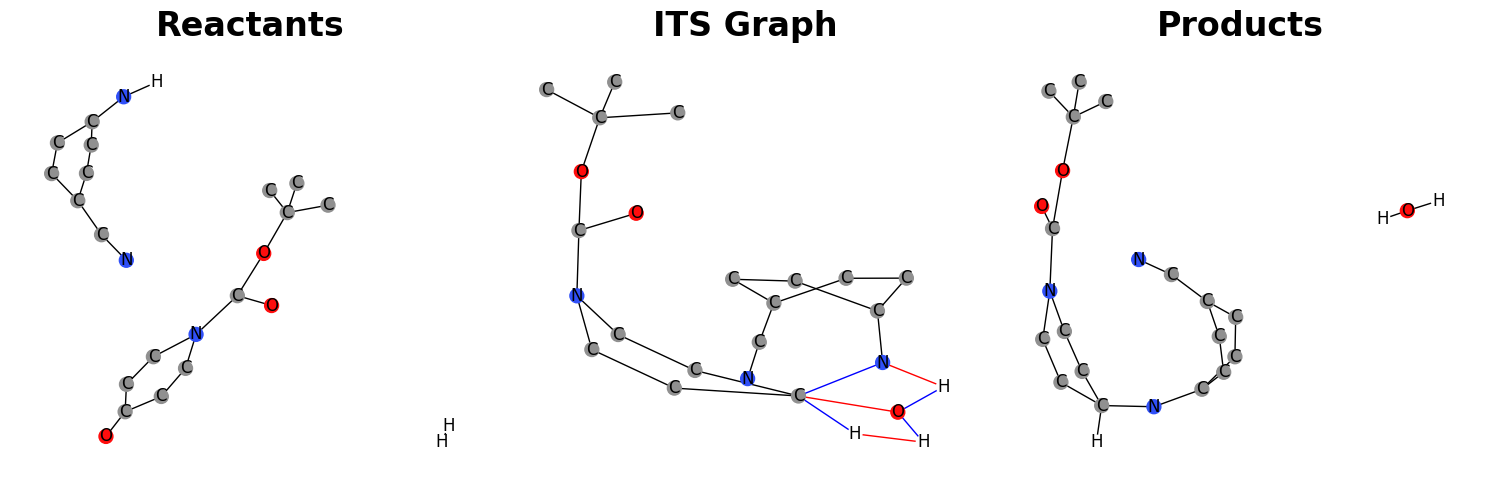

In [23]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

In [122]:
for i in react.nodes(data=True):
    print(i)

(12, {'charge': 0, 'hcount': 0, 'aromatic': False, 'element': 'F', 'atom_map': 12, 'isomer': 'N', 'partial_charge': -0.206, 'hybridization': 'SP3', 'in_ring': False, 'explicit_valence': 1, 'implicit_hcount': 0, 'neighbors': ['C']})
(11, {'charge': 0, 'hcount': 0, 'aromatic': True, 'element': 'C', 'atom_map': 11, 'isomer': 'N', 'partial_charge': 0.14, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0, 'neighbors': ['C', 'C', 'F']})
(13, {'charge': 0, 'hcount': 1, 'aromatic': True, 'element': 'C', 'atom_map': 13, 'isomer': 'N', 'partial_charge': 0.011, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0, 'neighbors': ['C', 'C']})
(14, {'charge': 0, 'hcount': 0, 'aromatic': True, 'element': 'C', 'atom_map': 14, 'isomer': 'N', 'partial_charge': 0.129, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0, 'neighbors': ['C', 'C', 'F']})
(16, {'charge': 0, 'hcount': 1, 'aromatic': True, 'elemen

In [123]:
for i in prod.nodes(data=True):
    print(i)

(9, {'charge': 0, 'hcount': 2, 'aromatic': False, 'element': 'O', 'atom_map': 9, 'isomer': 'N', 'partial_charge': -0.412, 'hybridization': 'SP3', 'in_ring': False, 'explicit_valence': 2, 'implicit_hcount': 0, 'neighbors': []})
(13, {'charge': 0, 'hcount': 1, 'aromatic': True, 'element': 'C', 'atom_map': 13, 'isomer': 'N', 'partial_charge': 0.01, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0, 'neighbors': ['C', 'C']})
(11, {'charge': 0, 'hcount': 0, 'aromatic': True, 'element': 'C', 'atom_map': 11, 'isomer': 'N', 'partial_charge': 0.132, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0, 'neighbors': ['C', 'C', 'F']})
(12, {'charge': 0, 'hcount': 0, 'aromatic': False, 'element': 'F', 'atom_map': 12, 'isomer': 'N', 'partial_charge': -0.206, 'hybridization': 'SP3', 'in_ring': False, 'explicit_valence': 1, 'implicit_hcount': 0, 'neighbors': ['C']})
(10, {'charge': 0, 'hcount': 0, 'aromatic': True, 'element': 'C', 'at

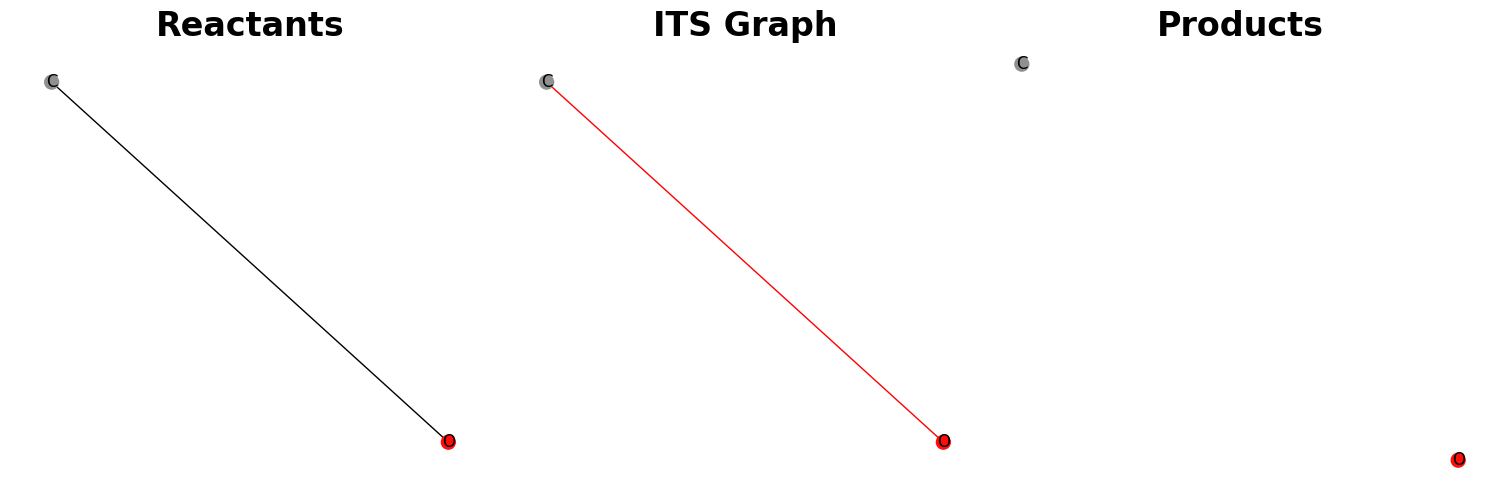

In [95]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(batch_processed[0]['GraphRules'])

In [2]:
test = [{'id': 'US20050136444A1', 'class': 1, 'reactions': 'N=C(N)NN.O=Cc1ccc(F)cc1F>>N=C(N)NN=Cc1ccc(F)cc1F', 'rxn_mapper': '[NH:1]=[C:2]([NH2:3])[NH:4][NH2:5].O=[CH:6][c:7]1[cH:8][cH:9][c:10]([F:11])[cH:12][c:13]1[F:14]>>[NH:1]=[C:2]([NH2:3])[NH:4][N:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([F:11])[cH:12][c:13]1[F:14]', 'graphormer': '[F:12][c:11]1[cH:10][cH:9][c:8]([CH:7]=[O:6])[c:14]([cH:13]1)[F:15].[NH2:5][NH:4][C:2]([NH2:3])=[NH:1]>>[F:12][c:11]1[cH:10][cH:9][c:8]([c:14]([cH:13]1)[F:15])[CH:7]=[N:5][NH:4][C:2]([NH2:3])=[NH:1]', 'local_mapper': '[NH:1]=[C:2]([NH2:3])[NH:4][NH2:5].O=[CH:6][c:7]1[cH:8][cH:9][c:10]([F:11])[cH:12][c:13]1[F:14]>>[NH:1]=[C:2]([NH2:3])[NH:4][N:5]=[CH:6][c:7]1[cH:8][cH:9][c:10]([F:11])[cH:12][c:13]1[F:14]'}]

In [3]:
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s


In [4]:
its_good

[{'R-id': 'N/A',
  'ITSGraph': (<networkx.classes.graph.Graph at 0x7fb030d6ab10>,
   <networkx.classes.graph.Graph at 0x7fb030d7d250>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7fb030d7f4d0>,
   <networkx.classes.graph.Graph at 0x7fb030d7fa90>)}]

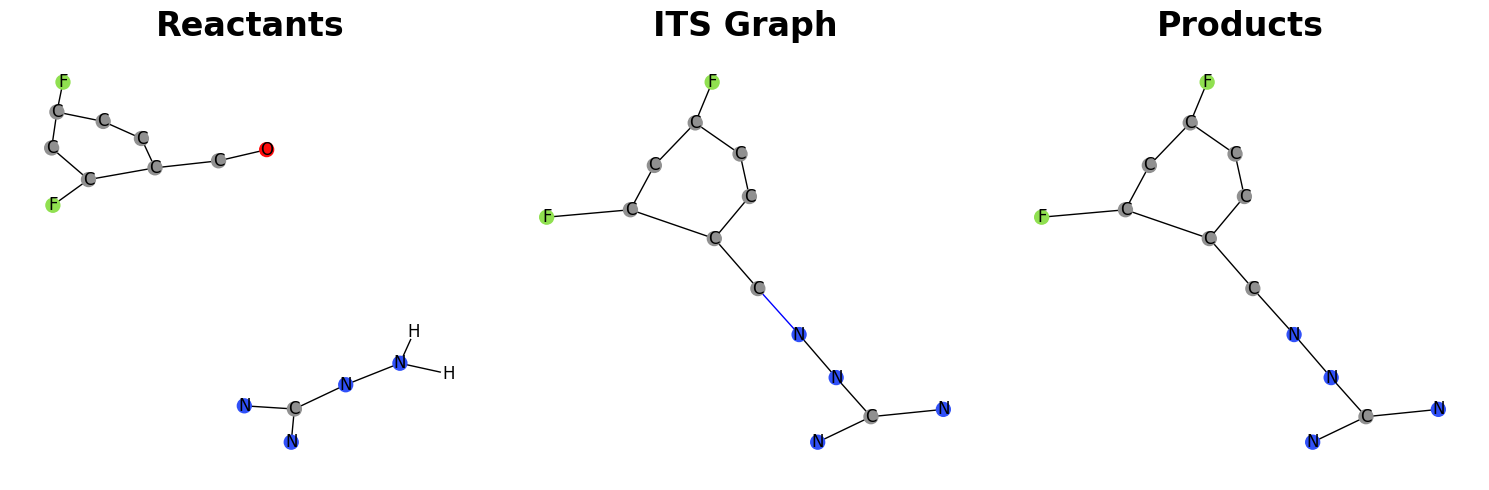

In [33]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

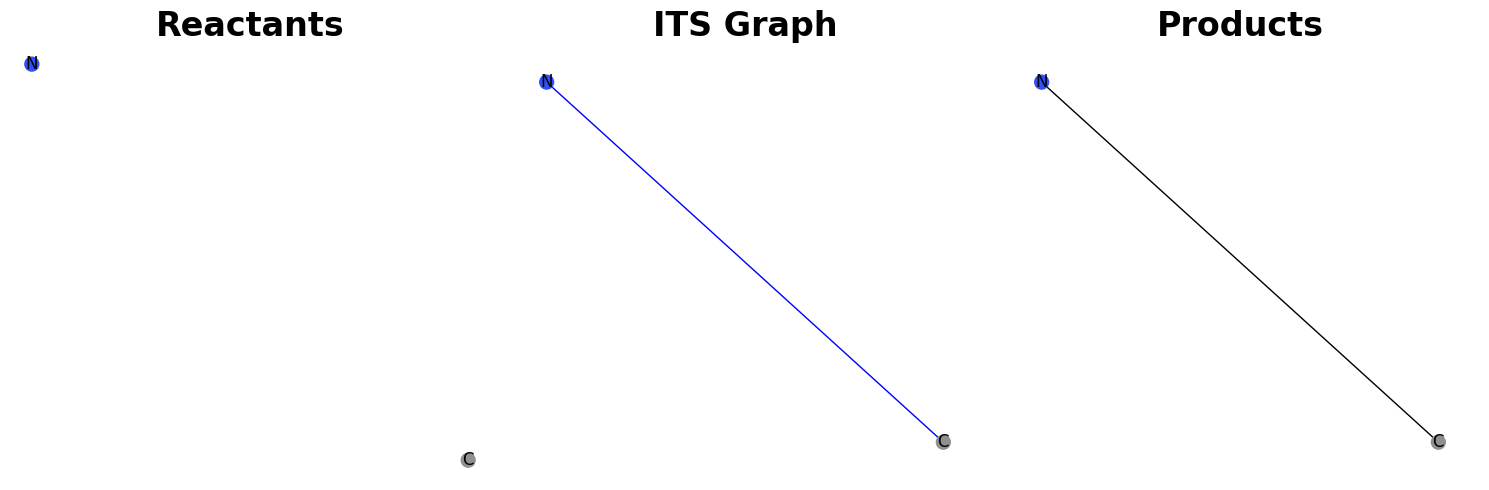

In [9]:
vis_graph.vis_three_graph(batch_processed[0]['GraphRules'])

In [6]:
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=1, verbose=2
            )

ERROR:root:{'R-id': 'N/A', 'ITSGraph': (<networkx.classes.graph.Graph object at 0x7faf891a2a10>, <networkx.classes.graph.Graph object at 0x7faf8700bf90>, <networkx.classes.graph.Graph object at 0x7faf87033290>), 'GraphRules': (<networkx.classes.graph.Graph object at 0x7faf86e59f90>, <networkx.classes.graph.Graph object at 0x7faf86e583d0>, <networkx.classes.graph.Graph object at 0x7faf86e58590>)}


2


In [10]:
batch_processed

[{'R-id': 'N/A',
  'ITSGraph': (<networkx.classes.graph.Graph at 0x7f7669d08390>,
   <networkx.classes.graph.Graph at 0x7f7668af3890>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x7f7668b2fc10>,
   <networkx.classes.graph.Graph at 0x7f7668b2db90>)}]